# Plos Alternatives
## Binary Threshold + Volume Thresholding

After we discovered that the PLOS pipeline does not work for our data, we will now be switching to a simple binary threshold and volume threshold to remove background noise. We will begin with a binary threshold at different percentile cutoffs to see what value gives us the most relevant clusters. After connected components and the clusters are labeled, we will then use a volume threshold based off of Richard Roth's metrics to see whether the clusters remaining appear to be synapses.

### Pseudocode:
The algorithm will take in a raw image matrix and then run the intensity/volume thresholds.

**Inputs:** 
1. Raw image data
**Outputs:**
1. List of thresholded clusters.

**Function(data)**
    1. data = binaryThreshold(percentile, data)   #Binary thresholds image at certain percentile of intensities.
    2. clusters = connectedComponents(data)       #Clusters and labels remaining values into clusters.
    3. finalClusters = volumeThreshold(clusters)  #Clusters above or below certain volume metrics get removed.
    4. RETURN finalClusters                       #Returns list of final clusters     
    
### Algorithm Code:

In [1]:
import sys
sys.path.insert(0, '../code/functions/')
import connectLib as cLib
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
from cluster import Cluster
from mpl_toolkits.mplot3d import Axes3D
import cv2
import mouseVis as mv
import tiffIO as tIO
from scipy import ndimage
from scipy import sparse

'''
dataSubset = tIO.unzipChannels(tIO.loadTiff('../data/SEP-GluA1-KI_tp2.tif'))[0][0:5]
plt.imshow(dataSubset[0], cmap="gray")
plt.show()
'''
#binary threshold
def binaryThreshold(img, percentile=90):
    img = (img/256).astype('uint8')
    threshImg = np.zeros_like(img)
    percentile = np.percentile(img, percentile)
    for i in range(len(img)):
        threshImg[i] = cv2.threshold(img[i], percentile, 255, cv2.THRESH_BINARY)[1]
    return threshImg

#Connected components and volume thresholding
def clusterThresh(volume, lowerFence=0, upperFence=250):
    # the connectivity structure matrix
    s = [[[1 for k in xrange(3)] for j in xrange(3)] for i in xrange(3)]

    # find connected components
    labeled, nr_objects = ndimage.label(volume, s)

    #volume thresholding with upperFence
    mask = labeled > labeled.mean()
    sizes = ndimage.sum(mask, labeled, range(nr_objects + 1))
    mask_size = sizes > upperFence
    remove_pixel = mask_size[labeled]
    labeled[remove_pixel] = 0
    labeled, nr_objects = ndimage.label(labeled, s)

    if not lowerFence == 0:
        #volume thresholding with lowerFence
        mask = labeled > labeled.mean()
        sizes = ndimage.sum(mask, labeled, range(nr_objects + 1))
        mask_size = sizes < lowerFence
        remove_pixel = mask_size[labeled]
        labeled[remove_pixel] = 0
        labeled, nr_objects = ndimage.label(labeled, s)

    #convert labeled to Sparse
    sparseLabeledIm = np.empty(len(labeled), dtype=object)
    for i in range(len(labeled)):
        sparseLabeledIm[i] = sparse.csr_matrix(labeled[i])

    clusterList = []

    #converting to clusterList
    for label in range(1, nr_objects + 1):

        memberList = []

        for z in range(len(sparseLabeledIm)):
            memberListWithoutZ = np.argwhere(sparseLabeledIm[z] == label)
            memberListWithZ = [[z] + list(tup) for tup in memberListWithoutZ]
            memberList.extend(memberListWithZ)

        if not len(memberList) == 0:
            clusterList.append(Cluster(memberList))

    return clusterList

def plosAlternative(data, percentile=90, lowerThresh=20, upperThresh = 230):
    img = binaryThreshold(data, percentile)
    clusterList = clusterThresh(img, lowerThresh, upperThresh)
    return clusterList, img

## Simulation Data
Almost the exact same simulation that we used for Precision&Recall as well as Connected Components. I generated a smaller volume size so plots are easier to analyze.  

Description: Validation testing will be performed on a a 50 x 50 x 50 volume. The synapse pixels will be grouped together in clusters as they would in the true data. Based on research into the true size of synapses, these synthetic synapse clusters will be given area of ~1 micron ^3, or about 139 voxels (assuming the synthetic data here and the real world data have identical resolutions). Pixel intensity distributions are ignored in this simulation because we just want to study how the synapses are being clustered. Therefore, the correct "total" number of synapses is relatively unimportant compared to the ratio of true positives/false positives/ false negatives of our pipeline. In this simulation, synapses make up 8% of the data.

Evaluation: I will be evaluating each step in the pipeline through plot.ly graphs (look at it) and evaluating the final algorithm using Precision and Recall.

### Raw Synthetic Data:

In [5]:
from random import randrange as rand
from skimage.measure import label

def generatePointSet():
    center = (rand(0, 50), rand(0, 50), rand(0, 50))
    toPopulate = []
    for z in range(-3, 2):
        for y in range(-3, 2):
            for x in range(-3, 2):
                curPoint = (center[0]+z, center[1]+y, center[2]+x)
                #only populate valid points
                valid = True
                for dim in range(3):
                    if curPoint[dim] < 0 or curPoint[dim] >= 50:
                        valid = False
                if valid:
                    toPopulate.append(curPoint)
    return set(toPopulate)
    
def generateTestVolume():
    #create a test volume
    clusterList = []
    volume = np.zeros((50, 50, 50))
    myPointSet = set()
    for _ in range(rand(60, 100)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
        clusterList.append(Cluster([elem for elem in potentialPointSet]))
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = 60000
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    noiseVolume[z][y][x] = rand(0, 10000)
    return volume, noiseVolume, clusterList

testVolume = generateTestVolume()
foreground = testVolume[0]
combinedIm = testVolume[1]
trueClusterList = testVolume[2]

## Displaying Simulation Data

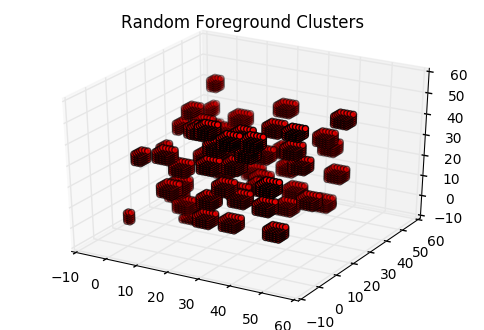

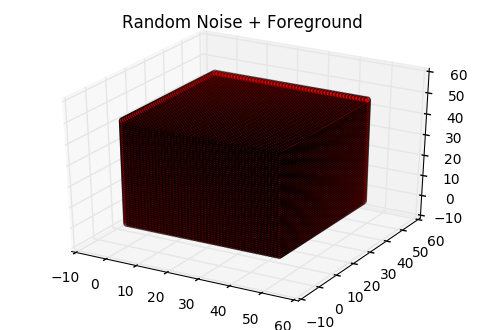

In [6]:
#displaying the random clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = foreground.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.title('Random Foreground Clusters')
plt.show()

#displaying the noise
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = combinedIm.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.title('Random Noise + Foreground')
plt.show()

<Container object of 50 artists>

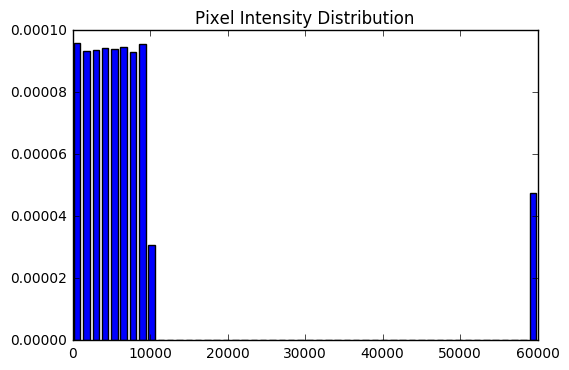

In [7]:
#displaying distribution of intensity
fig = plt.figure()
plt.title("Pixel Intensity Distribution")
hist, bins = np.histogram(combinedIm, bins=50, normed=True)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

plt.bar(center, hist, align='center', width=width)

In [9]:
print np.percentile(combinedIm, 95)

60000.0


### Why this Simulation is Good:
The 90th percentile of the pixel intensities is the value of our foreground clusters. That means the binary threshold should filter out all of the background. 


## Running Pipeline on Simulation:

In [34]:
#jank binary threshold for simulated data
def plosAlternative2(data, percentile=90, upperThresh=200, lowerThresh=0):
    array_np = np.asarray(data)
    low_values_indices = array_np < np.percentile(data, percentile)
    array_np[low_values_indices] = 0
    clusterList = clusterThresh(array_np, lowerThresh, upperThresh)
    return clusterList

clusters = plosAlternative2(combinedIm, 95, 250, 80)

In [35]:
print len(trueClusterList)
print len(clusters)

63
43


## Plotting True Clusters

In [28]:
## Plotting all true cluster members and the centroids of the true positive clusters.
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.graph_objs import *
init_notebook_mode()

trueMembers = []
for cluster in trueClusterList:
    for member in cluster.members:
        trueMembers.append(member)

trace0 = Scatter3d(
    x=[member[2] for member in trueMembers],
    y=[member[1] for member in trueMembers],
    z=[member[0] for member in trueMembers],
    mode='markers',
    marker=dict(
        size=3,
        color = 'red'
    ),
    opacity=1
)

data = [trace0]
layout = Layout(
    showlegend=False,
)

fig = dict( data=data, layout=layout )

iplot(fig)

## Plotting True clusters with Thresholded Clusters:

In [29]:
threshMembers = []
for cluster in clusters:
    for member in cluster.members:
        threshMembers.append(member)

trace0 = Scatter3d(
    x=[member[2] for member in trueMembers],
    y=[member[1] for member in trueMembers],
    z=[member[0] for member in trueMembers],
    mode='markers',
    marker=dict(
        size=3,
        color = 'red'
    ),
    opacity=.5
)

trace1 = Scatter3d(
    x=[member[2] for member in threshMembers],
    y=[member[1] for member in threshMembers],
    z=[member[0] for member in threshMembers],
    mode='markers',
    marker=dict(
        size=3,
        color = 'blue'
    ),
    opacity=.8
)

data = [trace0, trace1]
layout = Layout(
    showlegend=False,
)

fig = dict( data=data, layout=layout )

iplot(fig)

## Precision and Recall

In [20]:
def f1score(trueClusterList, testClusterList):
    
    tp = 0
    fp = 0
    fn = 0
    
    testClusterTuples = []
    for elem in testClusterList:
        myTupleList = []
        members = elem.members
        for member in members:
            myTupleList.append(tuple(member))
        testClusterTuples.append(myTupleList)

    trueClusterTuples = []
    for elem in trueClusterList:
        myTupleList = []
        members = elem.members
        for member in members:
            myTupleList.append(tuple(member))
        trueClusterTuples.append(myTupleList)
    
    truePositives = []
    for testList in testClusterTuples:
        found = False
        for trueList in trueClusterTuples:
            if len(set(testList).intersection(set(trueList))) > 0:
                found = True
        if found:
            truePositives.append(testList)
            tp+=1
    
    fp = len(testClusterList) - tp
    fn = len(trueClusterList) - tp
    precision = float(tp)/float(fp+tp)
    recall = float(tp)/float(tp+fn)
    f1 = (2*precision*recall)/(precision+recall)
    
    return precision, recall, f1

In [22]:
precision, recall, f1 = f1score(trueClusterList, clusters)

In [23]:
print 'Binary+Volume Threshold:'
print '\tPrecision: ', precision
print '\tRecall: ', recall
print '\tf1: ', f1

Binary+Volume Threshold:
	Precision:  1.0
	Recall:  0.68253968254
	f1:  0.811320754717


## Simulation Analysis:
The results are very promising. The only clusters that were missed were edge cases where the volume was cutoff (therefore it didn't pass through the volume threshold) or where the volume was combined (so it was too large to pass the threshold). We are also discounting clusters on the edge of the graph. What is very nice to see is that we got 100% precision, meaning that everything our pipeline detected was correct.

Downside: This is very dependent on the parameters we give it. Meaning that depending on the pixel intensity distribution for the image, we might get subpar results.

Note: I did increase the upper volume threshold to see if we would get more clusters. We were able to get 2 more extremely large clusters. Each cluster was made up of three closely connected test clusters. This proves the above hpothesis that our false negatives were from the upper volume threshold.


# Real Data

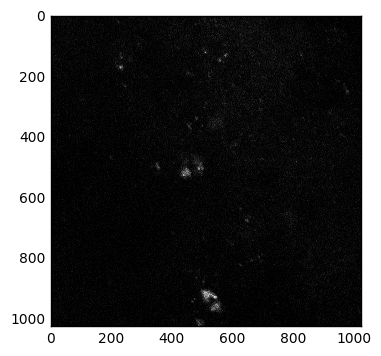

In [2]:
dataSubset = tIO.unzipChannels(tIO.loadTiff('../data/SEP-GluA1-KI_tp2.tif'))[0][5:10]
plt.imshow(dataSubset[2], cmap="gray")
plt.show()

In [11]:
clusters, img = plosAlternative(dataSubset, 90, 30, 300)

In [12]:
print len(clusters)

731


In [13]:
clusterVols = []
for cluster in clusters:
    clusterVols.append(cluster.getVolume())

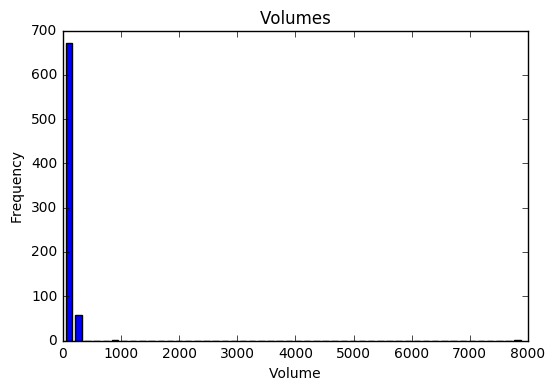

In [14]:
#displaying distribution of volumes

hist, bins = np.histogram(clusterVols, bins=50)
plt.title('Volumes')
plt.xlabel('Volume')
plt.ylabel('Frequency')
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()


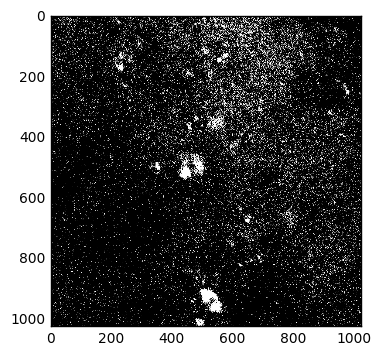

In [15]:
plt.imshow(img[2], cmap="gray")
plt.show()

In [16]:
img = mv.visualize(2, dataSubset, clusters)

In [17]:
cv2.imwrite('final50Thresh.png', img)

True

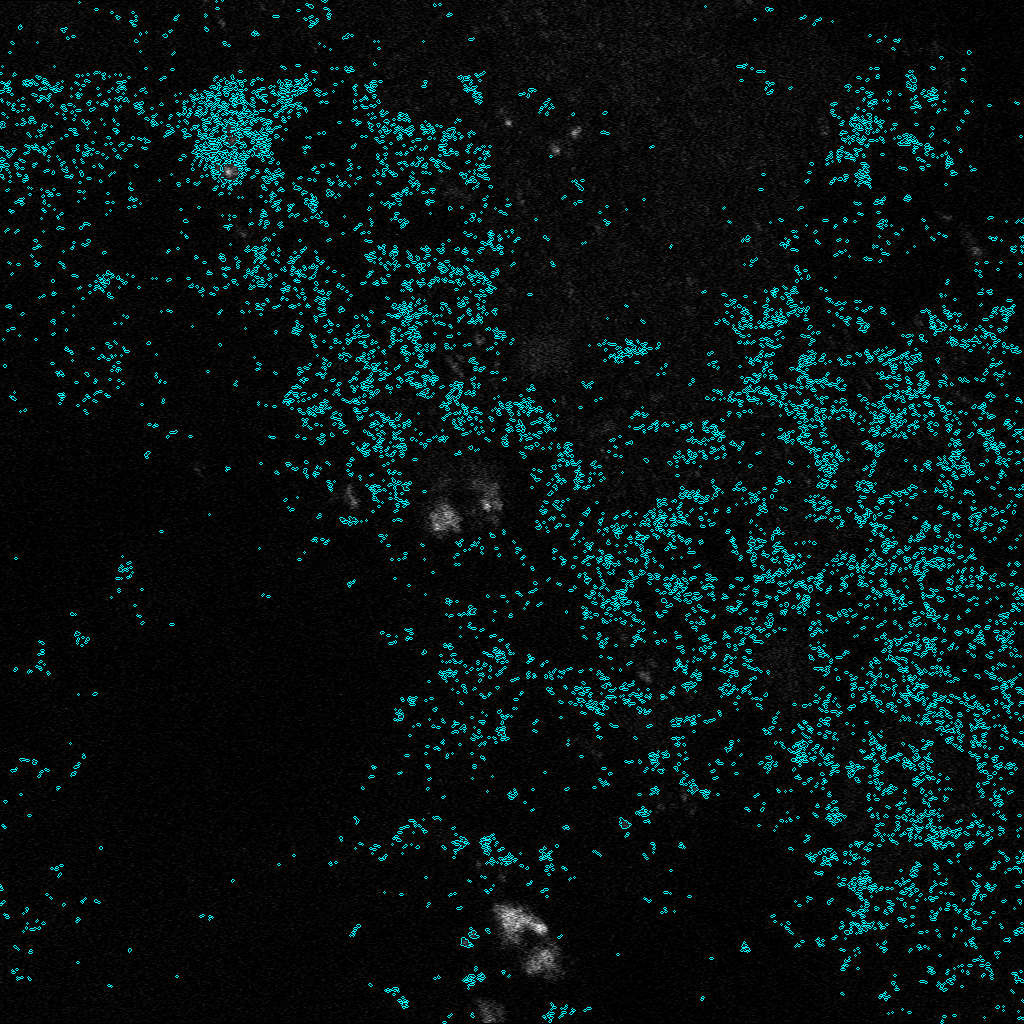

In [10]:
from IPython.display import Image
Image('final.png')


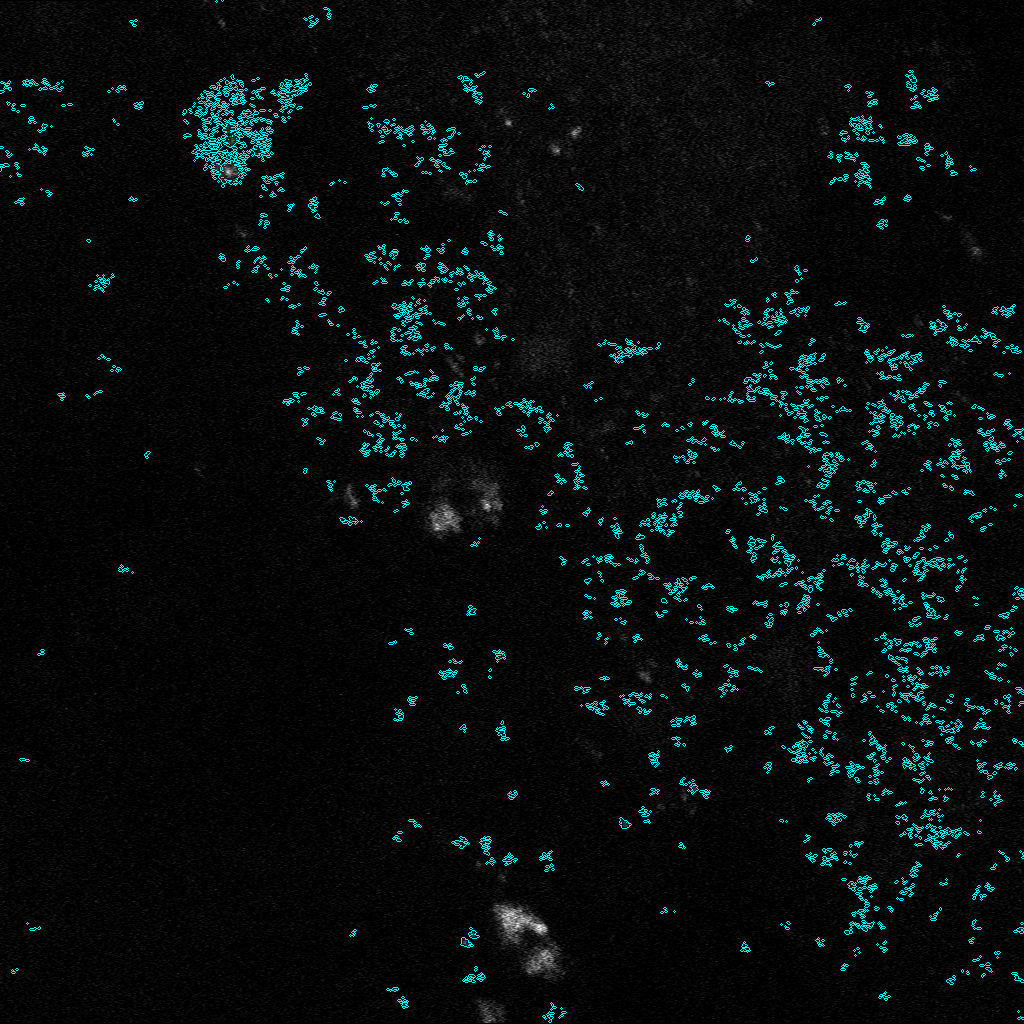

In [19]:
from IPython.display import Image
Image('final50thresh.png')


## Conclusion:

The number of clusters is dependent on how harsh we want to make the thresholding. But the results look good depending on the parameters. Still no ground truth so can't make sure yet. Some next steps would be making an adaptive threshold per every 5 slices or so. 